<a href="https://colab.research.google.com/github/BDonadelli/Codigos-em-financas/blob/main/Bollinger.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>


ESTRATÉGIA

1. fechou fora-fechou dentro com o ultimo fechamento 3 tr da sma20, entra no rompimento de máxima / mínima do ultimo dia
2. stop no fundo/topo do ff-fd, saída se chegar na media 20 dos fechamentos



In [15]:
import pandas as pd
import numpy as np
import copy
import datetime
import yfinance as yf
import os

In [16]:
def reset_data() :
  data=pd.read_csv(os.getcwd()+'/data/data.csv')
  data.set_index(data['Date'],inplace=True)
  data.drop(columns=['Date'],axis=1,inplace=True)
 

In [17]:
codigo = str(input('codigo ='))
periodo='max'

In [18]:
data = pd.DataFrame()
data = yf.download(tickers=codigo+'.SA' , period=periodo , progress = False  , auto_adjust=True)

In [19]:
import talib 

data['u_bb'], data['bb_m'], data['l_bb'] = talib.BBANDS(data['Close'], timeperiod = 20)
data['atr'] = talib.ATR(high=data['High'],close=data['Close'],low=data['Low'], timeperiod=20)

In [20]:
data

Open       High        Low      Close    Volume       u_bb  \
Date                                                                          
2000-01-03   1.462411   1.480169   1.462411   1.462411    585600        NaN   
2000-01-04   1.448483   1.451617   1.427591   1.427591    782400        NaN   
2000-01-05   1.410182   1.427591   1.410182   1.427591   1876800        NaN   
2000-01-06   1.427591   1.462411   1.427591   1.427591    792000        NaN   
2000-01-07   1.445002   1.487133   1.445002   1.479821   5347200        NaN   
...               ...        ...        ...        ...       ...        ...   
2024-09-02  58.820000  58.880001  58.419998  58.740002  13155000  60.005735   
2024-09-03  57.950001  57.950001  56.470001  56.549999  29504400  60.013033   
2024-09-04  56.700001  57.439999  56.470001  56.990002  19501800  60.011596   
2024-09-05  56.889999  57.639999  56.730000  57.400002  16585500  60.016281   
2024-09-06  57.500000  57.520000  56.580002  56.680000  17917900  60.021273   

               bb_m       l_bb       atr  
Date                                      
2000-01-03      NaN        NaN       NaN  
2000-01-04      NaN        NaN       NaN  
2000-01-05      NaN        NaN       NaN  
2000-01-06      NaN        NaN       NaN  
2000-01-07      NaN        NaN       NaN  
...             ...        ...       ...  
2024-09-02  57.6560  55.306265  0.998069  
2024-09-03  57.6180  55.222967  1.061666  
2024-09-04  57.6075  55.203405  1.057082  
2024-09-05  57.6350  55.253720  1.049728  
2024-09-06  57.6160  55.210728  1.044242  

[6200 rows x 9 columns]

In [21]:
data.dropna(inplace=True)
data.to_csv(os.getcwd()+'/data/data.csv')

### entrada

In [22]:
desvio = 2.95 # atrs

# Compra
signalB = np.where((data['Close'].shift(2) < data['l_bb'].shift(2))        #anteontem fechou fora
                  & (data['Close'].shift(1) > data['l_bb'].shift(1))       #ontem fechou dentro
                  & (np.abs(data['Close'] - data['bb_m']) > desvio*data['atr']) # e fechou longe da média
                  & (data['Close'] >= np.maximum(data['Close'].shift(1),data['Close'].shift(2)) ) # hoje rompeu as maximas
                  , 1, 0)
# Venda descoberta
signalS = np.where((data['Close'].shift(2) > data['u_bb'].shift(2))          #anteontem fechou fora
                  & (data['Close'].shift(1) < data['u_bb'].shift(1))         #ontem fechou dentro
                  & (np.abs(data['Close'] - data['bb_m']) > desvio*data['atr'])   # e fechou longe da média
                  & (data['Close'] <= np.minimum(data['Close'].shift(1),data['Close'].shift(2)) ) # hoje rompeu as minimas
                  , -1, 0)
data['signal'] = signalB + signalS

In [23]:
aux = data[(data['signal']== 1) | (data['signal']== -1)].copy()

### saída

In [24]:
m=len(data)

i=0
while (i < m -1) :
    while (i < m -1 and data['signal'].iloc[i] == 0) : i+=1
    j=i
    if data['signal'].iloc[j] == 1 :
        while (j < m-1 and data['Close'].iloc[j] < data['bb_m'].iloc[j]  ) : j+=1
    else:
        while (j < m-1 and data['Close'].iloc[j] > data['bb_m'].iloc[j]  ) : j+=1
    # data.iloc[i:j,'signal'] = data['signal'].iloc[i]
    data.loc[data.index[i]:data.index[j],'signal'] = data['signal'].iloc[i]

    i=j+1



In [25]:
data

Open       High        Low      Close    Volume       u_bb  \
Date                                                                          
2000-01-31   1.671327   1.671327   1.671327   1.671327         0   1.811198   
2000-02-01   1.636507   1.636507   1.636507   1.636507    148800   1.799979   
2000-02-02   1.650435   1.650435   1.566869   1.566869    739200   1.782675   
2000-02-03   1.549459   1.601688   1.549459   1.566869   4382400   1.758704   
2000-02-04   1.566869   1.626062   1.566869   1.626062    345600   1.738189   
...               ...        ...        ...        ...       ...        ...   
2024-09-02  58.820000  58.880001  58.419998  58.740002  13155000  60.005735   
2024-09-03  57.950001  57.950001  56.470001  56.549999  29504400  60.013033   
2024-09-04  56.700001  57.439999  56.470001  56.990002  19501800  60.011596   
2024-09-05  56.889999  57.639999  56.730000  57.400002  16585500  60.016281   
2024-09-06  57.500000  57.520000  56.580002  56.680000  17917900  60.021273   

                 bb_m       l_bb       atr  signal  
Date                                                
2000-01-31   1.620230   1.429261  0.033200       0  
2000-02-01   1.630675   1.461372  0.033281       0  
2000-02-02   1.637639   1.492604  0.035796       0  
2000-02-03   1.644603   1.530503  0.036617       0  
2000-02-04   1.651915   1.565641  0.037746       0  
...               ...        ...       ...     ...  
2024-09-02  57.656000  55.306265  0.998069       0  
2024-09-03  57.618000  55.222967  1.061666       0  
2024-09-04  57.607500  55.203405  1.057082       0  
2024-09-05  57.635000  55.253720  1.049728       0  
2024-09-06  57.616000  55.210728  1.044242       0  

[6180 rows x 10 columns]

In [26]:
import plotly.graph_objects as go
from plotly.subplots import make_subplots

fig = make_subplots(rows=3, cols=1) #go.Figure()
fig.add_trace(go.Scatter(x = data.index , y = data['Close'].values , name="preço"),1,1)
fig.add_trace(go.Scatter(x = data.index , y = data['u_bb'].values, mode='lines', 
                         line=dict(color='firebrick', width=2, dash='dash'), name="mms20"),1,1)
fig.add_trace(go.Scatter(x = data.index , y = data['l_bb'].values, mode='lines', 
                         line=dict(color='gray', width=2, dash='dash'), name="upper bb"),1,1)
fig.add_trace(go.Scatter(x = data.index , y = data['bb_m'].values, mode='lines', 
                         line=dict(color='gray', width=2, dash='dash'), name="lower bb"),1,1)
fig.add_trace(go.Scatter(x = aux.index, y = data['Close'] , mode='markers' ,name='sinal',
                             marker=dict(size=12, symbol="arrow", angle=45, line=dict(width=2, color="DarkSlateGrey"))
                         ),1,1)
fig.update_traces(
    marker=dict(size=12, symbol="arrow", angle=45, line=dict(width=2, color="DarkSlateGrey")),
    selector=dict(mode="markers"),
)
# fig.add_trace(go.Scatter(x = df.loc[sai].index, y = df.loc[sai]['Close '+ativo] , mode='markers' ,name='Saida',
#                          marker=dict(size=12, symbol="arrow", angle=-135, line=dict(width=2, color="red"))
#                          ),1,1)
fig.add_trace(go.Scatter(x = data.index , y = data['signal'].values , name="sinal"),2,1)


fig.add_trace(go.Scatter(x =data.index , y = data['atr'].values*desvio , mode='lines', name=f"{desvio}*ATR"),3,1)


fig.show()

In [27]:
data['retrn'] =  np.log(data['Close']) - np.log(data['Close'].shift(1))
data['strategy_returns'] = data['retrn'] * (data['signal'].shift(1))

In [28]:
print(f"Strategy returns: {data['strategy_returns'].cumsum().iloc[-1]}")


Strategy returns: -0.2726508476559432


In [29]:
print("Buy and hold returns:",data['retrn'].cumsum().iloc[-1])


Buy and hold returns: 3.5238032876110914


In [30]:
df = data.copy()
df["Date"]=df.index

# feriados

inicio = df.index[0].strftime("%Y-%m-%d")
fim = df.index[-1].strftime("%Y-%m-%d")

url = 'https://raw.githubusercontent.com/BDonadelli/Codigos-em-financas/main/data/feriados.csv'

feriado = pd.read_csv(url)
feriado['Data'] =  pd.to_datetime(feriado['Data'], format='%d/%m/%Y')
feriado.set_index(feriado.Data, inplace=True)
feriado['Data'] = feriado['Data'].astype(str)
lista = feriado.Data.loc[inicio:fim].values

# feriados

# import plotly.io as pio
# pio.renderers.default = 'vscode'


fig = make_subplots(rows=3, cols=1,
                          #shared_xaxes=True,
                          vertical_spacing=0.05,
                          subplot_titles=(codigo, 'sinal C/V', 'ATR'),
                          row_width=[0.1, 0.2, 0.4])

fig.append_trace({ 'x': df.Date,
           'open': df.Open,
           'close': df.Close,
           'high': df.High,
           'low': df.Low,
           'type': 'candlestick',
           'name': codigo,
           'showlegend': True }
, row=1, col=1 )

fig.append_trace(go.Scatter( name="sma20",
                 line=dict(color='lightblue'),
    x=df.index,
    y=df.bb_m,
), row=1, col=1)

fig.append_trace(go.Scatter( name="sma20 + 2dp",
                 line=dict(color='lightgreen'),
    x=df.index,
    y=df.u_bb,
), row=1, col=1 )

fig.append_trace(go.Scatter( name="sma20 - 2dp",
                 line=dict(color='lightgreen'),
    x=df.index,
    y=df.l_bb,
), row=1, col=1)

fig.append_trace(go.Scatter(x = data.index , y = data['signal'].values , name="sinal"),2,1)
fig.update_traces(
    marker=dict(size=12, symbol="arrow", angle=45, line=dict(width=2, color="DarkSlateGrey")),
    selector=dict(mode="markers"),)

fig.append_trace(go.Scatter( name="sinal C/V",
    x = df.Date,
    y = df.atr,
), row=3, col=1)

fig.append_trace(go.Scatter( name="sinal C/V",
    x = df.Date,
    y = df.signal,
), row=2, col=1)

fig.update_xaxes(
        rangeslider_visible=False,
        rangebreaks=[
            # {'pattern':'day of week' , 'bounds':[6,1] , 'pattern':'hour' , 'bound':[18,10]},
            # NOTE: Below values are bound (not single values), ie. hide x to y
            #dict(bounds=["sat", "mon"]),  # hide weekends, eg. hide sat to before mon
            #dict(bounds=[16, 9.5], pattern="hour"),  # hide hours outside of 9.30am-4pm
            dict(values=lista)#["2018-12-24","2019-12-24", "2020-12-24", "2021-12-24", "2022-12-24"]) ,
            #dict(values=["2018-12-25","2019-12-25", "2020-12-25", "2021-12-24", "2022-12-24"]) ,
            #dict(values=["2018-01-01","2019-01-01", "2020-01-01", "2021-01-01", "2022-01-01"])
        ]
    )

fig.update_layout(height=900, width=1200)

fig.show()


<Axes: xlabel='Date'>

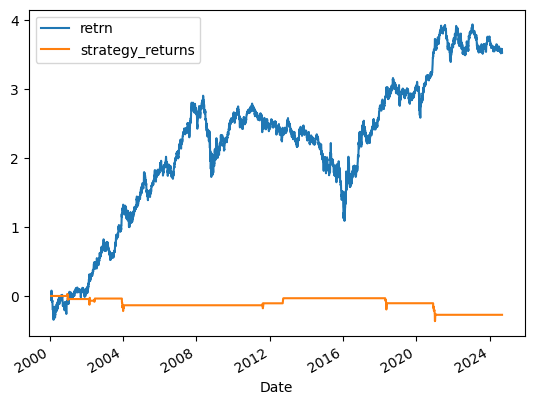

In [31]:
data[['retrn','strategy_returns']].cumsum().plot()


In [32]:
import quantstats as qs

help(qs.reports.full)

Help on function full in module quantstats.reports:

full(returns, benchmark=None, rf=0.0, grayscale=False, figsize=(8, 5), display=True, compounded=True, periods_per_year=252, match_dates=True, **kwargs)



                           Strategy
-------------------------  ----------
Start Period               2000-02-01
End Period                 2024-09-06
Risk-Free Rate             0.0%
Time in Market             3.0%

Cumulative Return          -26.24%
CAGR﹪                     -0.85%

Sharpe                     -0.22
Prob. Sharpe Ratio         13.64%
Smart Sharpe               -0.21
Sortino                    -0.29
Smart Sortino              -0.28
Sortino/√2                 -0.2
Smart Sortino/√2           -0.2
Omega                      0.77

Max Drawdown               -34.07%
Longest DD Days            8664
Volatility (ann.)          5.07%
Calmar                     -0.02
Skew                       -2.23
Kurtosis                   195.27

Expected Daily %           -0.0%
Expected Monthly %         -0.1%
Expected Yearly %          -1.21%
Kelly Criterion            -14.24%
Risk of Ruin               0.0%
Daily Value-at-Risk        -0.53%
Expected Shortfall (cVaR)  -0.53%

Max Consecutive 

None

Start      Valley         End  Days  Max Drawdown  99% Max Drawdown
1  2000-12-18  2021-01-07  2024-09-06  8664    -34.070164        -27.272691

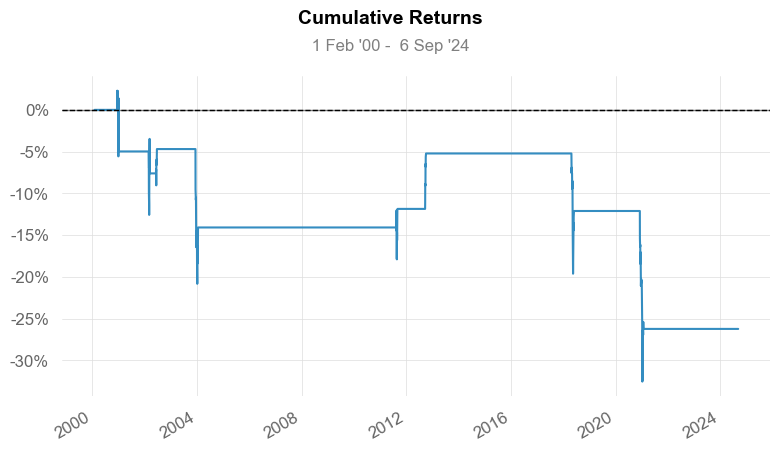

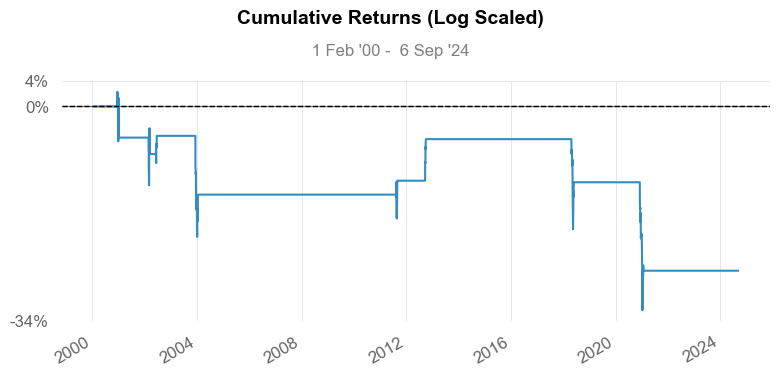

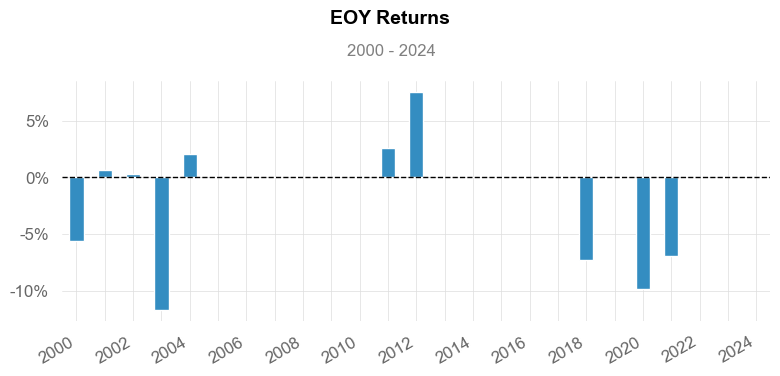

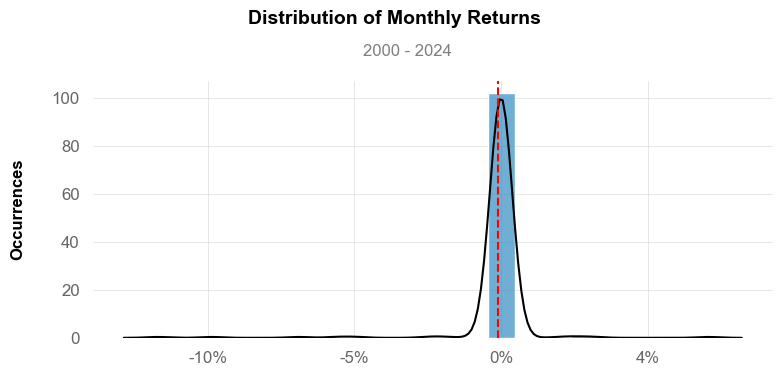

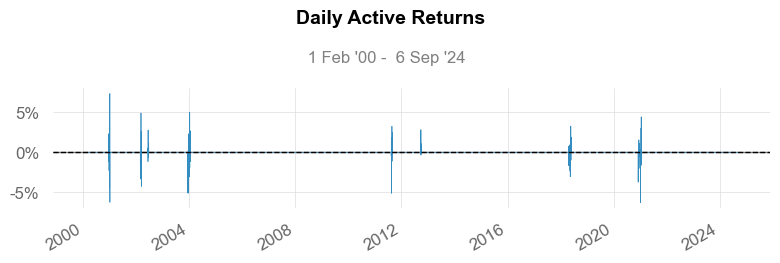

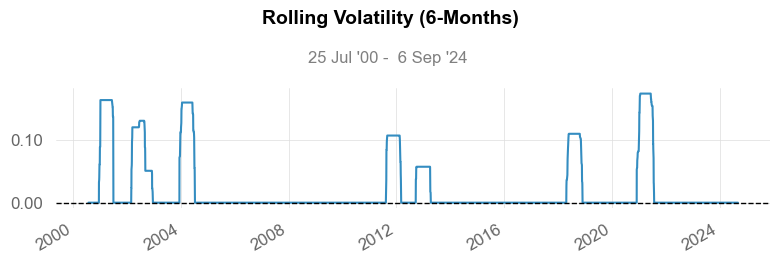

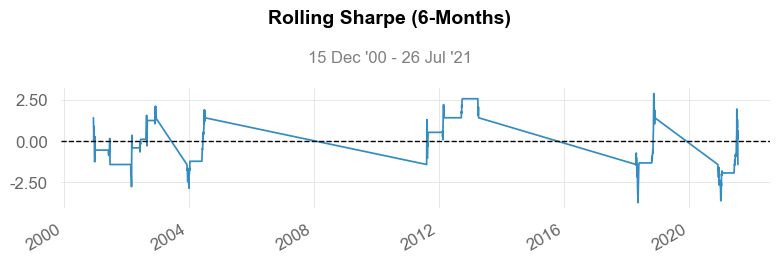

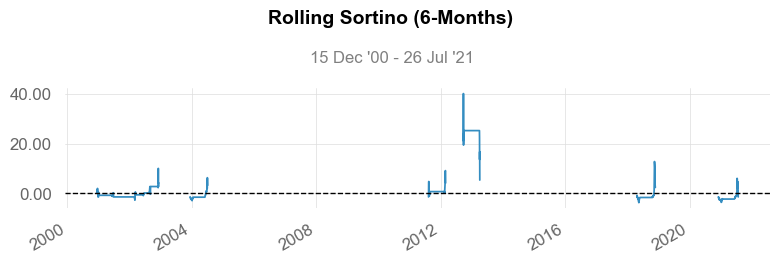

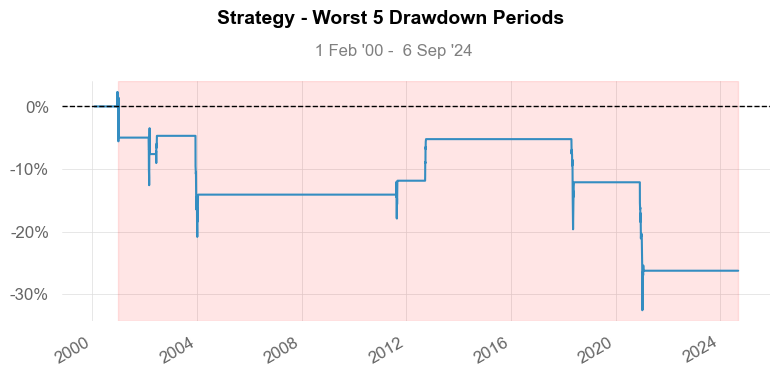

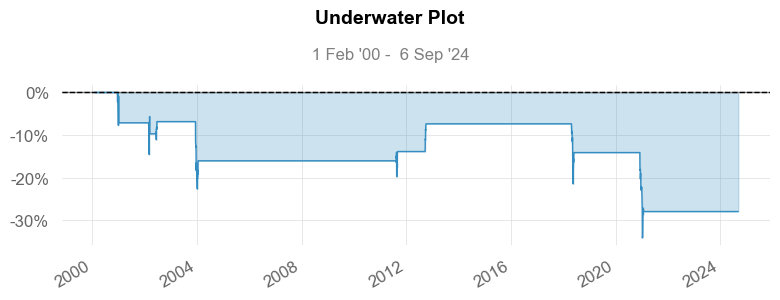

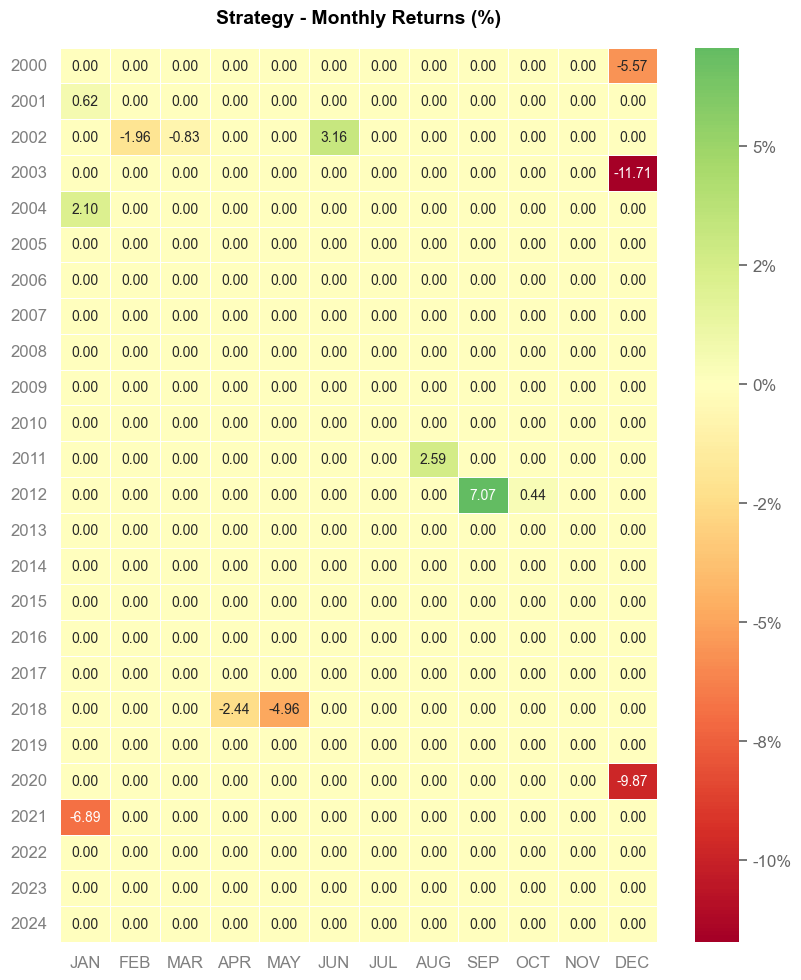

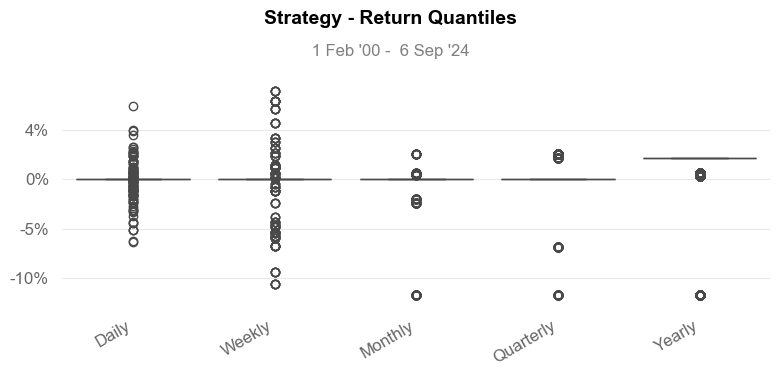

In [33]:
import warnings
# Suppress FutureWarning messages
warnings.simplefilter(action='ignore', category=FutureWarning)

qs.reports.full(data['strategy_returns'])

In [34]:
data[['retrn','strategy_returns']]

retrn  strategy_returns
Date                                  
2000-01-31       NaN               NaN
2000-02-01 -0.021054              -0.0
2000-02-02 -0.043485              -0.0
2000-02-03  0.000000               0.0
2000-02-04  0.037082               0.0
...              ...               ...
2024-09-02 -0.014199              -0.0
2024-09-03 -0.037996              -0.0
2024-09-04  0.007751               0.0
2024-09-05  0.007168               0.0
2024-09-06 -0.012623              -0.0

[6180 rows x 2 columns]